## Jac Royston Rees: 961103
## Optimisation Coursework: Developing Optimisers Within Python

**1. Which stochastic optimiser did you choose?**
For Task 3, I decided on using Simulated Annealing as my Stochastic Optimiser, 


In [1]:
##import required packages
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import itertools
import math
from scipy.stats import truncnorm
import random
import scipy
np.set_printoptions(suppress=True) #Suppress scientific notation

In [2]:
minimized_items= np.array(['Diameter of The wire', 'Mean Diameter Of Coil', 'Number of Active Coils']) #define the 3 dimensions

In [3]:
##Set the seed
np.random.seed(3)

## Feasible Space Criteria:



In [4]:
f_count = 0
g1_count = 0
g2_count = 0 #Create a counter for each constraint as-well as the number of times f_count has been called
g3_count = 0
g4_count = 0

In [5]:
def f(x):
    global f_count #reference the global variable
    f_count += 1 #increment the counter by 1
    x1, x2, x3 = x #obtain x1,x2,x3 from the vector x
    res = np.multiply(np.multiply(x1**2,x2),2+x3)
    return res #return result

In [6]:
def g1(x):
    global g1_count #reference the global variable
    g1_count += 1 #increment counter by 1
    x1,x2,x3 = x #obtain x1,x2,x3 from the vector x
    res =  1 - np.divide(np.multiply(x2**3,x3), np.multiply(71785,x1**4)) 
    return res #return the result of the calculation

In [7]:
def g2(x):
    global g2_count #reference the global variable
    g2_count += 1 #increment counter by 1
    x1,x2,x3 = x #obtain x1,x2,x3 from the vector x
    component1 = np.divide(np.multiply(4, np.power(x2, 2)) - np.multiply(x1, x2), np.multiply(12566,(np.multiply(x2, np.power(x1, 3))-1))) #compute the first component
    component2 = np.divide(1, np.multiply(51208, np.power(x1, 2))) #compute the second component
    res= (component1 + component2) - 1
    return res#return the result of the calculation
    
    

In [8]:
def g3(x): 
    global g3_count #reference the global variable
    
    g3_count += 1 #increment by one
    x1,x2,x3 = x # obtain x1,x2,x3 from the vector x
    res = (1- np.divide(np.multiply(140.45, x1), np.multiply(np.power(x2,2),x3)))
    return res

In [9]:
def g4(x):
    global g4_count #reference the global variable
    g4_count +=1 #increment counter by 1
    x1,x2,x3 = x # obtain x1,x2,x3 from the vector x
    res = (np.divide(x1+x2, 1.5) - 1)
    return res

## Adaptive Penalty

In [10]:
p = 0
lambda_t = 0

In [11]:
def adaptive(x, f, constraints,  beta1, beta2):
    global p
    global lambda_t
    if(p >= 5):
        #print('case 1')
        lambda_t = np.multiply(np.divide(1, beta1), lambda_t)
    if(p <= -2):
        #print('case 2')
        lambda_t = np.multiply(beta2, lambda_t)
    else:
        #print('case 3')
        lambda_t = lambda_t
        
    #print(p)
    return np.multiply(lambda_t, np.max([0, constraints(x)]))**2

In [12]:
def phi_adaptive(x, f, constraints, beta1, beta2 ):
    return np.add(f(x), adaptive(x, f, constraints, beta1, beta2))

## Create constraints subject to: $\bar{g}(x)=max_{g_i}g_i(x) \leq 0$

In [13]:
def constraints(x): 
    x1,x2,x3 = x #obtain x1,x2,x3 from the vector x
    return max(g1(x), g2(x),g3(x), g4(x)) #Returns true or false depending on whether all results return values below the specified inequality constraints

In [14]:
def bounds(x):

#Check whether each scalar within the vector satisfies corresponding bounds
    x1,x2,x3 = x
    if(x1 >= 0.05 and x1 <= 2):
        if(x2 <= 1.3 and x2 >= 0.25):
            if(x3 <= 15 and x3 >= 2):
                return True
    return False

## Random Search And Simulated Annealing Algorithms:

In [15]:
def random_search(function, constraints, max_iter, lower_bound, 
                  upper_bound):
    """
    Random Search Algorithm. 
    
    parameters. 
    fucntion: The function to optimize
    k_vector: The constraints to abide by
    lower_bound: The 3 dimensional lower-bound vector
    uppwer_bound: The 3 dimensional upper-bound vector
    fargs: non-keyword arguments for the function
    
    returns best solution found and its function value. (best_x and best_y)
    """
   
    
    results = np.array([]) #create an empty array for the y values
    points = [] #create an empty array for the x vectors
   # print(points.shape)
    k = 0
    while k <max_iter: #iterate until it has performed 3000 valid iterations       
        point = np.random.uniform(low=lower_bound, high=upper_bound, size=len(lower_bound)) #obtain a random uniform vector of points within the bounds
        
        #print(point)
        if((constraints(point) <= 0) and bounds(point)): #check to see if it satisfies the constraints AND bounds
            results = np.append(results, np.float64(function(point))) #add the function result(y) to the results array
            points.append(point) #add the points vector to a list
            k += 1 #since it is a feasible solution, increment the k value
    
   
    best_ind = np.argmin(results) #get the index with the smallest y value
    #print(points.shape)
    return points[best_ind], results[best_ind]

    

In [16]:
def simulated_annealing(function, constraints, tk,k_max, lower_bound, upper_bound, gamma, search_percent,  fargs=()):
    
    """
    Simulated Annealing Algorithm. 
    
    parameters. 
    function: The function to optimize
    k_vector: The constraints to abide by
    tk = the initial temperature and thus the temperature after each iteration
    k_max = The number of function evaluations
    lower_bound: The 3 dimensional lower-bound vector
    upper_bound: The 3 dimensional upper-bound vector
    gamma: The decay rate
    search_percent: the variance to search the normal-distribution
    fargs: non-keyword arguments for the function
    
    returns best solution found and its function value. (best_x and best_y)
    """
    np.seterr(all='ignore') 
    
    k = 0 #initialise the variable k to zero
    global lambda_t
    global p
    p = 0
   
    satisfies = False #initialise the boolean to false to repeat searching for a random vector which satisfies the bounds and feasible space criteria
    results = np.array([]) #create an empty array of results
    sigma = (upper_bound - lower_bound) * search_percent #create a sigma vector of each area to search
    
    cov = ([[sigma[0], 0, 0], #create a 2D array for the Covariance Diagnol matrix using the values within the sigma vector
            [0, sigma[1], 0], 
            [0, 0, sigma[2]]])
    
 
    while(not satisfies):
        x_best = np.random.uniform(low = lower_bound, high = upper_bound, size = len(lower_bound)) #obtain a random uniform vector of points within the bounds
        
        if(bounds(x_best)): #check if the initial x_best satisfies the constraints and bounds
           
            satisfies = True # if it does; set the boolean to true to continue the algorithm
            p+=1
        else:
            p-=1
            
    

    y_best =  np.float64(function(x_best,  *fargs)) #obtain the new y_best
    xc, yc = x_best, y_best # center the search at xc,yc
    
    while(k < (k_max-1)): #minus 1 due to it already being called once previously
        
       
        x_prime = np.random.multivariate_normal(xc, cov) #obtain a new random vector for x_prime using a multivariate-normal distribution
        
        if(bounds(x_prime)): #check to see if it satisfies the constraints
            if(p <= 0):
                p = 1
            else:
                p += 1
            y_prime = np.float64(function(x_prime,*fargs)) #calculate the new y_prime from x_prime and corresponding function
            results = np.append(results, yc) #append the centered value (this is solely for testing and initial decrease)
            delta_y = y_prime - yc #take the centered y from the new y_prime


            #If statement to check whether we are assigning new xc and yc values
            if((delta_y <= 0) or ((np.random.uniform(low = 0, high = 1) < min(np.exp(np.true_divide(-delta_y, tk )), 1)))): 
                xc, yc = x_prime, y_prime

                    #If statement to see if we have obtained a new best minimised value
            if((y_prime < y_best)): 
                x_best, y_best = x_prime, y_prime
        else:
            if(p >= 0):
                p = -1
            else:
                p -= 1

            tk =  np.float64(gamma * tk) #decay the value of tk
            k+=1 #since everything is satisfied and accounted for we can now increment the value i for the while loop
            
        
    return x_best, y_best

## Initiate variables for each algorithm

In [17]:
tk = 10 # initial temperate
gamma = 0.75 #decay value
search_percent = 0.1
number_of_samples = 3000 #number of times which we can run feasible solutions
lower_bound = np.array([0.05, 0.25,2])
upper_bound = np.array([2, 1.3, 15])
beta1 = 2
beta2 = 1.5

## Run one iteration of each to determine optimum

In [18]:
x_best_rand, y_best_rand = random_search(f,constraints, number_of_samples, lower_bound, upper_bound)
#x_best_sim, y_best_sim = sim_anneal(f, constraints, tk,number_of_samples, lower_bound, upper_bound, gamma, search_percent)


In [19]:

x_best_sim, y_best_sim = simulated_annealing(phi_adaptive, constraints, tk,number_of_samples, lower_bound, upper_bound, gamma, search_percent, fargs=(f, constraints, beta1, beta2))

## Print the F-Count To Illustrate number of times the function has been called:

In [20]:
print('The Counter \'F Count\' has been called: ', f_count, ' times between the two algorithms')

The Counter 'F Count' has been called:  4073  times between the two algorithms


## Best Random Search Solution From One Run:

In [21]:
print(x_best_rand)
print("The Best Solution For Random Search:")
print("x1({}) with a value of: {}".format(minimized_items[0],x_best_rand[0]))
print("x2({}) with a value of: {}".format(minimized_items[1],x_best_rand[1]))
print("x3({}) with a value of: {}".format(minimized_items[2],x_best_rand[2]))
print("Minimized function with a value of: {}".format(y_best_rand))

[0.05123045 0.5933775  2.77359922]
The Best Solution For Random Search:
x1(Diameter of The wire) with a value of: 0.051230446462000055
x2(Mean Diameter Of Coil) with a value of: 0.593377496835132
x3(Number of Active Coils) with a value of: 2.77359922074091
Minimized function with a value of: 0.007434184026446937


## Best Simulated Annealing Solution From One Run:

In [22]:

print("The Best Solution For Simulated Annealing:")
print("x1({}) with a value of: {}".format(minimized_items[0],x_best_sim[0]))
print("x2({}) with a value of: {}".format(minimized_items[1],x_best_sim[1]))
print("x3({}) with a value of: {}".format(minimized_items[2],x_best_sim[2]))
print("Minimized function with a value of: {}".format(y_best_sim))

The Best Solution For Simulated Annealing:
x1(Diameter of The wire) with a value of: 0.05672351743874573
x2(Mean Diameter Of Coil) with a value of: 0.28099399409220777
x3(Number of Active Coils) with a value of: 2.205683963257381
Minimized function with a value of: 0.0038024190698777226


## Run each Algorithm 21 Times to Determine The Best Solution For Each:

In [23]:

n_repeats = 21 #Amount of times to run the experiments

res_random_x = [] #Empty Array of the appropriate size
res_random_y = np.array([]) #Empty list for the minimized values
res_simulated_x = []
res_simulated_y = np.array([])
for j in range(n_repeats):
    sim_i_x, sim_i_y = simulated_annealing(phi_adaptive, constraints, tk,number_of_samples, lower_bound, upper_bound, gamma, search_percent, fargs=(f, constraints, beta1, beta2))
    res_simulated_x.append(sim_i_x)
    res_simulated_y = np.append(res_simulated_y, sim_i_y)


for i in range(n_repeats): #Repeat the experiment 
    rand_i_x, rand_i_y = random_search(f, constraints, number_of_samples, lower_bound, upper_bound)
    res_random_x.append(rand_i_x) #Append the best x values to the array
    res_random_y = np.append(res_random_y, rand_i_y) #append the best y values to the array



In [24]:
#res_simulated_x = res_simulated_x[0:21, :] #Decrease size of the Simaneal experiment to the first 21 instances
#res_random_x = res_random_x[0:21, :] #Decrease size of the random experiment to the first 21 instances
np.set_printoptions(suppress=True) #Display the values NOT in scientific notation(e.g. 1.233e-39)
res_simulated_x = np.array(res_simulated_x) #convert list to matrix
res_random_x = np.array(res_random_x) #convert list to matrix


In [25]:
#res_random_x = np.append(res_random_x, x_best_rand)
#res_random_y = np.append(res_random_y, y_best_rand)

#res_simulated_x = np.append(res_simulated_x, x_best_sim)
#res_simulated_y = np.append(res_simulated_y, y_best_sim)

rand_index = np.argmin(res_random_y)
x_best_rand_index = res_random_x[rand_index]
y_best_rand_index = res_random_y[rand_index]

sim_index = np.argmin(res_simulated_y)
x_best_sim_index = res_simulated_x[sim_index]
y_best_sim_index = res_simulated_y[sim_index]

In [26]:
print(res_simulated_x)

[[ 0.05016469  0.25812414  9.63606478]
 [ 0.05434748  0.26344093  6.29779863]
 [ 0.05214229  0.27257834  2.65343216]
 [ 0.05056246  0.35013625 12.70404898]
 [ 0.05084076  0.28687053  6.37034888]
 [ 0.05446335  0.31528311  3.26789411]
 [ 0.05326272  0.30058238  6.74337217]
 [ 0.05264503  0.28670599  3.32935581]
 [ 0.05035717  0.2630167  10.43687222]
 [ 0.05228488  0.30409298  7.02378231]
 [ 0.05495829  0.30118392 11.50251657]
 [ 0.05031587  0.31838546  5.69222004]
 [ 0.05185534  0.27154951  7.86561544]
 [ 0.0512443   0.33011825  6.53830698]
 [ 0.05287039  0.2640839   2.53113543]
 [ 0.05142045  0.27702471  3.80489465]
 [ 0.0564782   0.30562664  2.22639423]
 [ 0.05732813  0.29809666 12.4980617 ]
 [ 0.05675862  0.25240755 12.88310568]
 [ 0.05036488  0.25356368 14.07130011]
 [ 0.05705433  0.27612583  3.80009567]]


## Best Random Search Solution After 21 Searches

In [27]:
print("The Best Solution For Random Search:")
print("x1({}) with a value of: {}".format(minimized_items[0],x_best_rand_index[0]))
print("x2({}) with a value of: {}".format(minimized_items[1],x_best_rand_index[1]))
print("x3({}) with a value of: {}".format(minimized_items[2],x_best_rand_index[2]))
print("Minimized function with a value of: {}".format(y_best_rand_index))

The Best Solution For Random Search:
x1(Diameter of The wire) with a value of: 0.050182300166068096
x2(Mean Diameter Of Coil) with a value of: 0.5950334635878566
x3(Number of Active Coils) with a value of: 2.232065951114705
Minimized function with a value of: 0.006341543049592764


## Best Simulated Annealing Solution After 21 Searches

In [28]:
print("The Best Solution For Simulated Annealing: ")
print("x1({}) with a value of: {}".format(minimized_items[0],x_best_sim_index[0]))
print("x2({}) with a value of: {}".format(minimized_items[1],x_best_sim_index[1]))
print("x3({}) with a value of: {}".format(minimized_items[2],x_best_sim_index[2]))
print("Minimized function with a value of: {}".format(y_best_sim_index))

The Best Solution For Simulated Annealing: 
x1(Diameter of The wire) with a value of: 0.05287039489550121
x2(Mean Diameter Of Coil) with a value of: 0.2640839012124097
x3(Number of Active Coils) with a value of: 2.5311354298629785
Minimized function with a value of: 0.0033448302200995163


## Plot 3-Dimensional with Colormap as Minimized Value

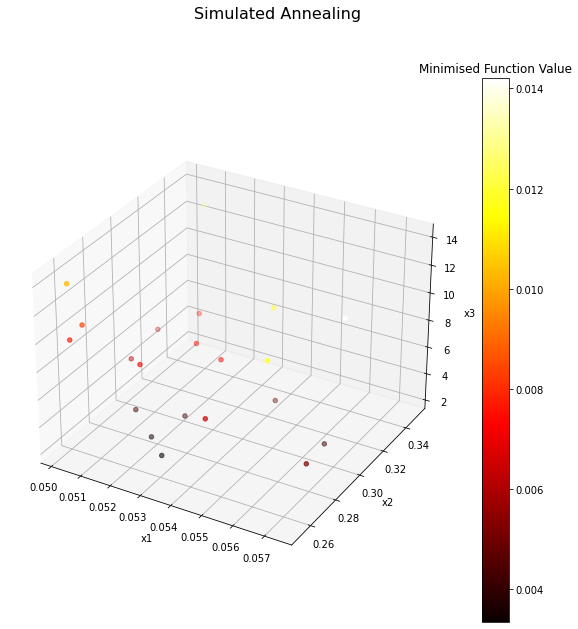

In [29]:

fig = plt.figure(figsize=(10,10)) #plot a figure of size...
fig.suptitle('Simulated Annealing', fontsize=16) #set title
ax = fig.add_subplot(111, projection='3d') #project it onto a 3-dimensional plane

#get each dimension value
x1 = res_simulated_x[:,0] 
x2 = res_simulated_x[:,1] 
x3 = res_simulated_x[:,2]
y = res_simulated_y
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
img = ax.scatter(x1, x2, x3, c = y, cmap = plt.hot())
clb = plt.colorbar(img) #use color as fourth/minimized dimension
clb.ax.set_title('Minimised Function Value')
plt.show()

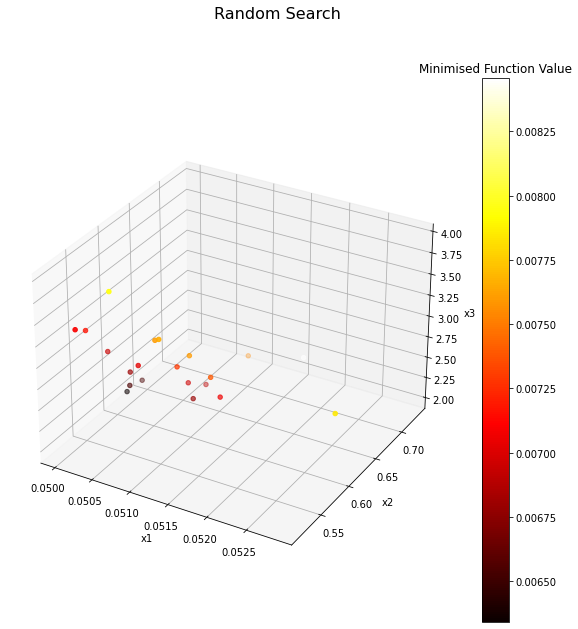

In [30]:
fig = plt.figure(figsize=(10,10)) #plot figure of size..
ax = fig.add_subplot(111, projection='3d') #Project onto 3-Dimensional plane
fig.suptitle('Random Search', fontsize=16)
#get each dimension value
x1 = res_random_x[:,0]
x2 = res_random_x[:,1]
x3 = res_random_x[:,2]
y = res_random_y
best_y = np.argmin(res_random_y)
best_x = res_random_x[best_y]


#set the labels
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')

img = ax.scatter(x1, x2, x3, c = y, cmap = plt.hot())
clb = plt.colorbar(img)
clb.ax.set_title('Minimised Function Value') #set fourth dimension title

plt.show()

## Plot Comparisons Between The Two Algorithms

Text(0, 0.5, 'Best Objective Value')

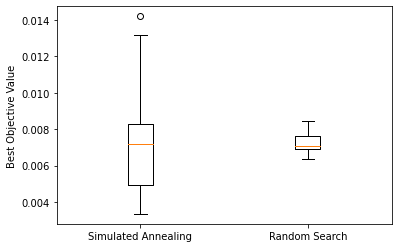

In [31]:
#Using a boxplot compare the 
plt.boxplot([res_simulated_y, res_random_y])
plt.xticks([1,2], ['Simulated Annealing', 'Random Search'])
plt.ylabel("Best Objective Value")